In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from utils import RandomClassificationExperiment

sns.set_theme()
sns.set(font_scale=1.3)

# Enable interactive plots
%matplotlib widget


## Confusion matrix

\begin{align*}
  TP &= p(y = k, \hat{y} = k) \\
     &= p(y = k)p(\hat{y} = k) \\
     &= pq \\
  TN &= p(y \neq k, \hat{y} \neq k) \\
     &= (1 - p(y = k))(1 - p(\hat{y} = k)) \\
     &= (1 - p)(1 - q) \\
  FP &= (1 - p)q \\
  FN &= p(1 - q)
\end{align*}

where $p: = p(y = k), q: = p(\hat{y} = k)$.

## Precision
\begin{align*}
  P &= \frac{TP}{TP + FP} \\
   &= \frac{pq}{pq + (1 - p)q} \\
   &= p
\end{align*}


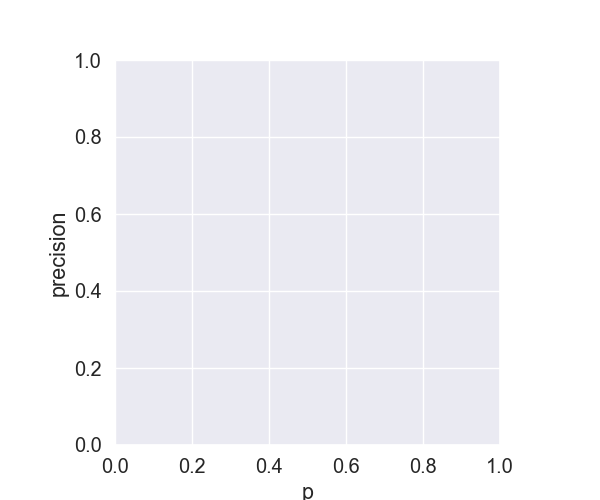

In [2]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=precision_score,
    metric_name="precision",
    param_name="q",
    animate=True,
).run()

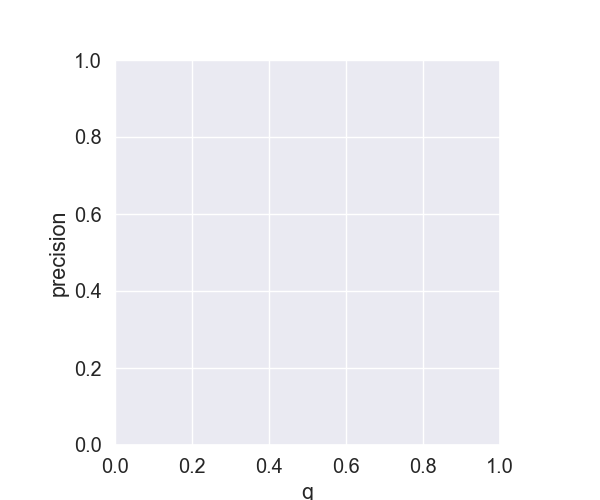

In [3]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=precision_score,
    metric_name="precision",
    param_name="p",
    animate=True,
).run()


## Recall 
\begin{align*}
  R &= \frac{TP}{TP + FN} \\
   &= \frac{pq}{pq + p(1 -q)} \\
   &= q
\end{align*}

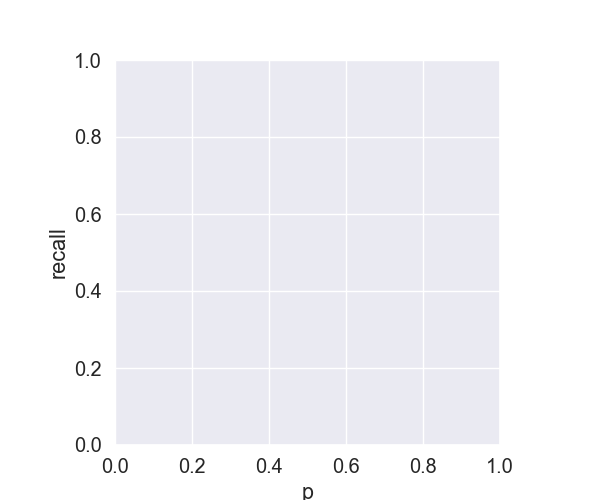

In [4]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=recall_score,
    metric_name="recall",
    param_name="q",
    animate=True,
).run()

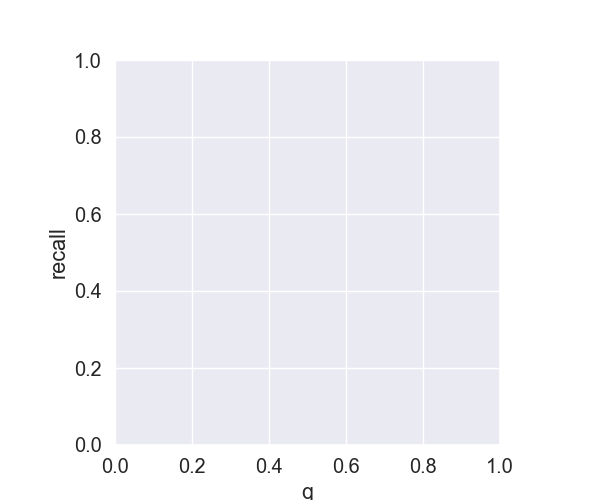

In [5]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=recall_score,
    metric_name="recall",
    param_name="p",
    animate=True,
).run()

## F1 score
\begin{align*}
  f1 &= 2\frac{PR}{P + R} \\
   &= 2\frac{pq}{p + q}
\end{align*}

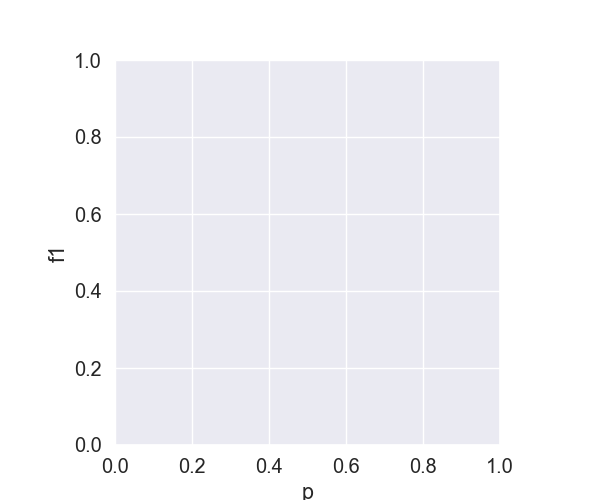

In [6]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=f1_score,
    metric_name="f1",
    param_name="q",
    animate=True,
).run()

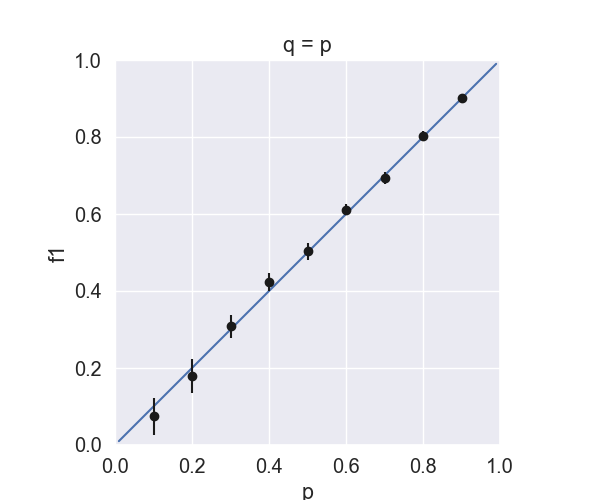

In [7]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    metric_func=f1_score,
    metric_name="f1",
).run()

## Accuracy
\begin{align*}
  ACC &= \frac{TP + TN}{TP + TN + FP + FN} \\
   &= \frac{pq + (1-p)(1-q)}{pq + (1-p)(1-q) + (1-p)q + p(1-q)} \\
   &= 1 + 2pq - p - q
\end{align*}

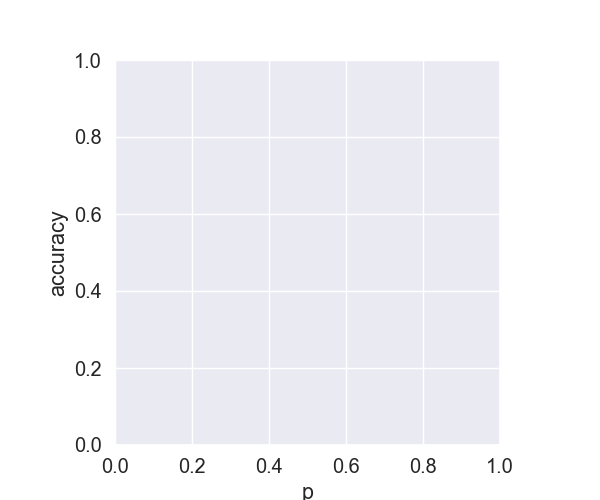

In [8]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=accuracy_score,
    metric_name="accuracy",
    param_name="q",
    animate=True,
).run()

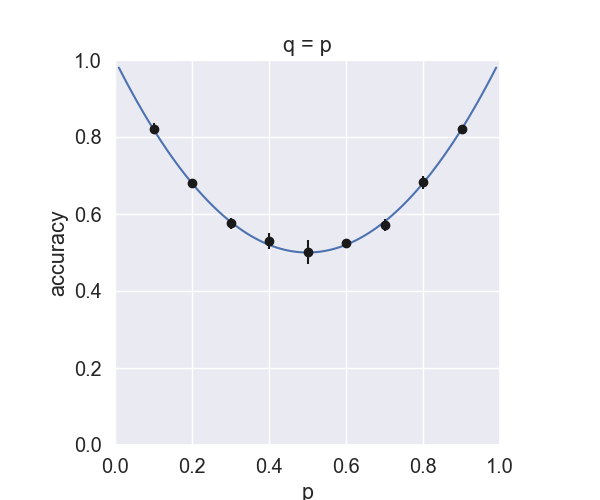

In [9]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    metric_func=accuracy_score,
    metric_name="accuracy",
).run()

## ROC-AUC

\begin{align*}
  TPR &= q \\
  FPR &= \frac{FP}{FP + TN} \\
      &= \frac{(1-p)q}{(1-p)q + (1-p)(1-q)}
      &= q \\
  AUC &= \frac{1}{2}
\end{align*}

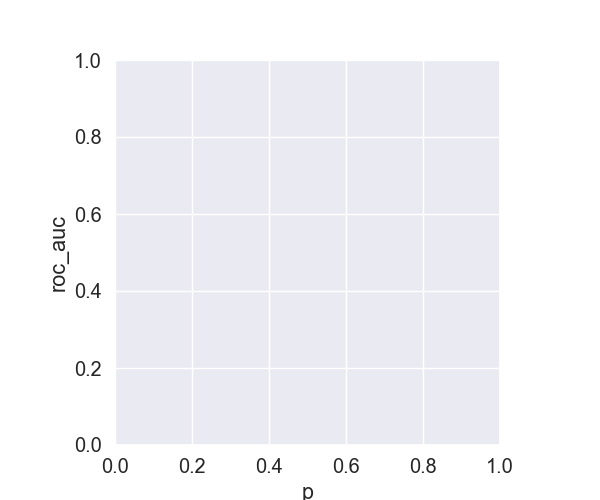

In [10]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    q_vec=np.arange(0.1, 1, 0.1),
    metric_func=roc_auc_score,
    metric_name="roc_auc",
    param_name="q",
    animate=True,
).run()

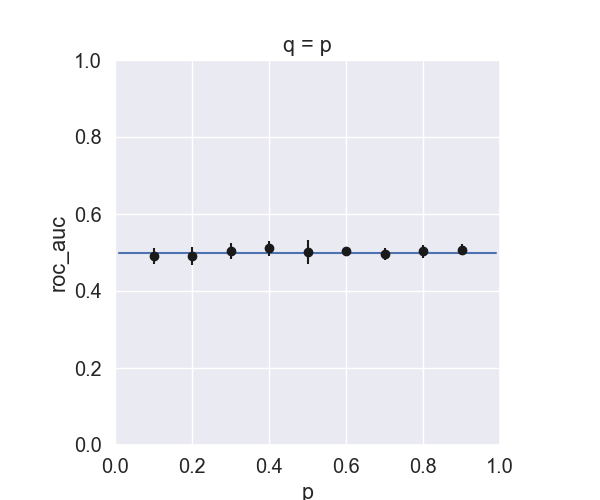

In [11]:
anim = RandomClassificationExperiment(
    p_vec=np.arange(0.1, 1, 0.1),
    metric_func=roc_auc_score,
    metric_name="roc_auc",
).run()